<a href="https://colab.research.google.com/github/wrzoskamil/UMWF/blob/main/Case3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-1b022a15d328>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Signal'] = best_rf.predict(X_test)


Generated signals:
Signal
0    55
1    32
Name: count, dtype: int64
Initial Cash: 100000
Final Cash: 115360.14999999995
Profit: 15360.14999999995


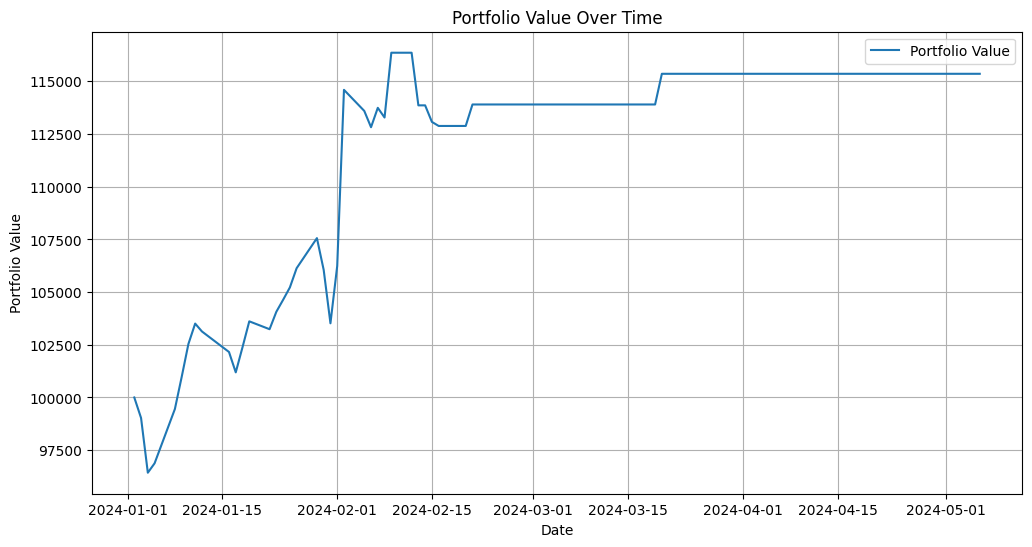

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Wczytywanie danych
file_path = 'BATS_AMZN, 1D_04611.csv'
data = pd.read_csv(file_path, parse_dates=['time'])
data.set_index('time', inplace=True)

# Obliczanie wskaźników technicznych
data['SMA_20'] = data['close'].rolling(window=20).mean()
data['SMA_50'] = data['close'].rolling(window=50).mean()

def compute_rsi(data, window):
    diff = data.diff(1).dropna()
    gain = (diff.where(diff > 0, 0)).rolling(window=window).mean()
    loss = (-diff.where(diff < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['close'], 14)
data.dropna(inplace=True)

# Zbiór uczący i testowy
train_data = data[:'2023-12-31']
test_data = data['2024-01-01':'2024-05-06']


features = ['SMA_20', 'SMA_50', 'RSI']
X_train = train_data[features]
y_train = np.where(train_data['close'].shift(-1) > train_data['close'], 1, 0)

X_test = test_data[features]

# Optymalizowanie modelu
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Generowanie sygnałów
test_data['Signal'] = best_rf.predict(X_test)

print("Generated signals:")
print(test_data['Signal'].value_counts())

# Backtest
initial_cash = 100000
cash = initial_cash
positions = 0
cash_history = []

for index, row in test_data.iterrows():
    if row['Signal'] == 1 and cash > row['close']:
        # sygnał zakupu
        shares_to_buy = cash // row['close']
        positions += shares_to_buy
        cash -= shares_to_buy * row['close']
    elif row['Signal'] == 0 and positions > 0:
        # sygnał sprzedaży
        cash += positions * row['close']
        positions = 0
    cash_history.append(cash + positions * row['close'])

# Końcowe metryki
final_cash = cash_history[-1]
profit = final_cash - initial_cash

print(f'Initial Cash: {initial_cash}')
print(f'Final Cash: {final_cash}')
print(f'Profit: {profit}')

#Wynik
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, cash_history, label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()